In [43]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MaxAbsScaler
from sklearn.cluster import AgglomerativeClustering, DBSCAN, KMeans
import gower
from scipy.cluster.hierarchy import dendrogram
from sklearn.decomposition import PCA
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.metrics import silhouette_score
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings("ignore")


In [32]:
# Load data
data = pd.read_csv(r"C:\Users\IM-KI\Documents\PrEvelOp_src\cleaned datasets\Ortlinghaus_cleaned.csv")
#column Fauf as index
data.set_index('Fauf', inplace=True)

In [33]:
### Preprocessing
# save all columns with DType object in list
cat_columns = data.select_dtypes(include=['object']).columns.tolist()

# save all columns with DType float64 or int64 in list
num_columns = data.select_dtypes(include=['float64', 'int64']).columns.tolist()

# split dataframe
data_num = data[num_columns]
data_cat = data[cat_columns]

In [34]:
# encode the categorical columns
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(data_cat)
data_cat_encoded = pd.DataFrame(data=enc.transform(data_cat).toarray(), index=data_cat.index, columns=enc.get_feature_names_out())

# scale the numerical columns with MaxAbsScaler
scaler = MaxAbsScaler().fit(data_num)
data_num_scaled = pd.DataFrame(data=scaler.transform(data_num), index=data_num.index, columns=data_num.columns)

# concatenate the subdataframes columnwise
data_prep = pd.concat([data_num_scaled, data_cat_encoded], axis=1)

In [35]:
data_prep

,Gesamtanzahl Bohrungen,Anzahl Bohrungen,Bohrungsdurchmesser [mm],Bohrungstiefe [mm],Duration,Average processing time,Average setup time,Average batch size,Number of operations,Bohrungsanordnung_CIRCULAR,...,Bohrungsart_Durchgangsbohrung,Bohrungsart_Durchgangsbohrung gesenkt,Bohrungsart_Durchgangsbohrung gestuft,Bohrungsart_Durchgangsgew.bohrung gest.,Bohrungsart_Durchgangsgewindebohrung,Bohrungsart_Gewindesackloch,Bohrungsart_Gewindesackloch gestuft,Bohrungsart_Sackloch gesenkt,Bohrungsart_Sackloch gestuft,Bohrungsart_Sacklochbohrung
Fauf,,,,,,,,,,,,,,,,,,,,,
13343620,0.283186,0.017241,0.039574,0.217573,0.010700,0.011921,0.293578,0.000200,0.153846,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
13343464,0.123894,0.206897,0.029787,0.464435,0.000000,0.000000,0.000000,0.000100,0.076923,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13343536,0.238938,0.275862,0.036170,0.364017,0.080670,0.011921,0.293578,0.000200,0.153846,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13342090,1.000000,0.034483,0.080851,0.376569,0.135289,0.020892,0.420489,0.000100,0.692308,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13342590,0.212389,0.034483,0.031915,0.020795,0.365787,0.005231,0.165138,0.000200,0.615385,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13341677,0.283186,0.068966,0.023404,0.050209,0.776175,0.028831,0.196483,0.001000,0.461538,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13337500,0.008850,0.017241,1.000000,0.020921,0.148537,0.895403,0.012232,0.033917,0.461538,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13339070,0.566372,0.034483,0.044681,0.125523,0.611003,0.017164,0.234964,0.000200,0.692308,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


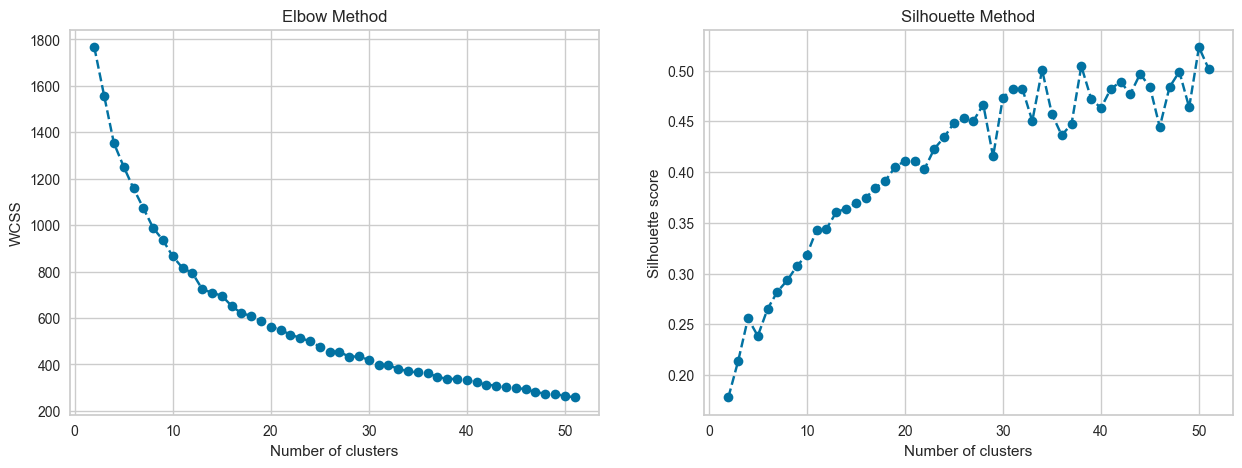

In [36]:
# apply elbow and shilouette method to preprocessed dataframe to find the optimal number of clusters
wcss = [] 
silhouette_avg = []
for i in range(2, 52): 
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(data_prep) 
    # wcss score
    wcss.append(kmeans.inertia_)
    # silhouette score
    silhouette_avg.append(silhouette_score(data_prep, kmeans.fit_predict(data_prep)))

# subplot with two plots
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
xticks = range(2, 52)
# plot wcss score
ax[0].plot(range(2, 52), wcss, marker='o', linestyle='--')
# plot silhouette score
ax[1].plot(range(2, 52), silhouette_avg, marker='o', linestyle='--')
# make x-labels
ax[0].set_xlabel('Number of clusters')
ax[1].set_xlabel('Number of clusters')
# make y-labels
ax[0].set_ylabel('WCSS')
ax[1].set_ylabel('Silhouette score')
# make title
ax[0].set_title('Elbow Method')
ax[1].set_title('Silhouette Method')
# show plot
plt.show()

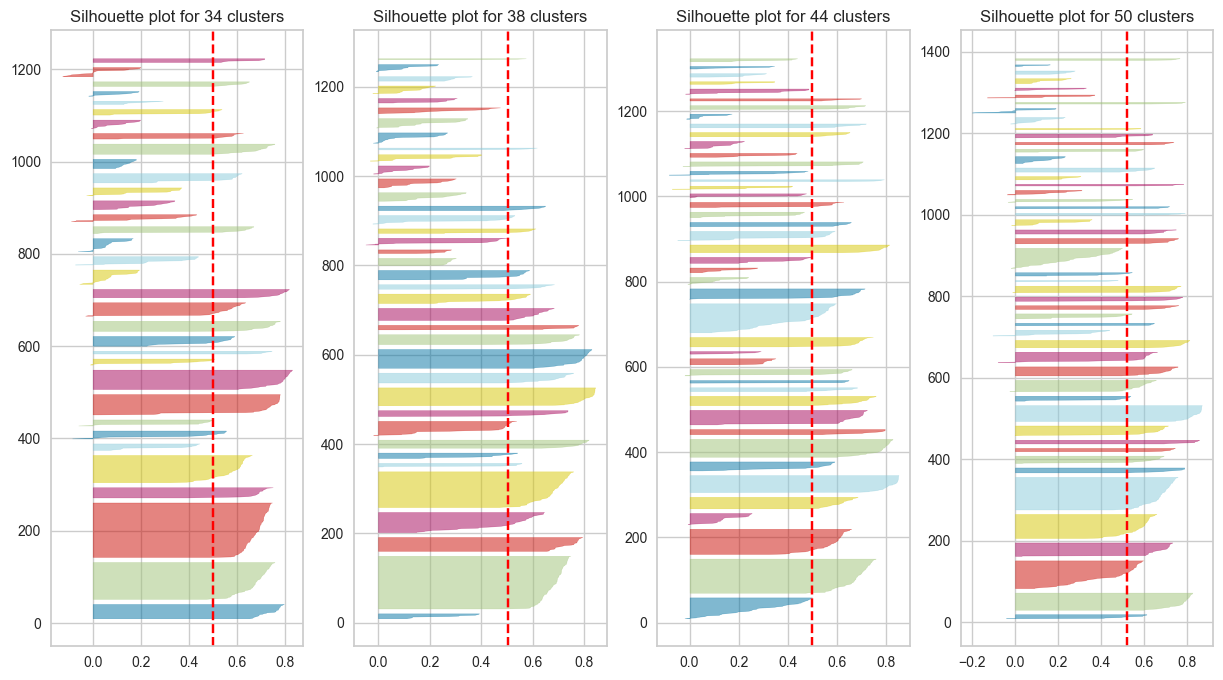

In [37]:
fig, ax = plt.subplots(1,4, figsize=(15,8))
q = 0
for i in [34, 38, 44, 50]:
    # Create KMeans instances for different number of clusters
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    # Create SilhouetteVisualizer instance with KMeans instance
    # Fit the visualizer
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q])
    # title for subplot
    ax[q].set_title('Silhouette plot for '+str(i)+' clusters')
    visualizer.fit(data_prep)
    q += 1

In [38]:
# calculate distance matrix with gower distance
distance_gower = gower.gower_matrix(data)

In [39]:
# elbow plot: we want to plot the number of clusters against the sum of within-cluster variance for linkage='average'
cluster_variance_average = []
for k in range(1,46):
    clustering = AgglomerativeClustering(n_clusters=k,  metric='precomputed', linkage='average', compute_distances=True).fit(distance_gower)
    cluster_variance_sum = []
    for i in range(k):
        cluster_indices = []
        for index, cluster in enumerate(list(clustering.labels_)):
            if cluster == i:
                cluster_indices.append(index)
        cluster_len = len(cluster_indices)
        cluster_df = data_prep.iloc[cluster_indices]
        cluster_df.loc['metoid'] = cluster_df.mean()
        cluster_variance = sum(gower.gower_matrix(cluster_df)[-1])
        cluster_variance_sum.append(cluster_variance)
    cluster_variance_average.append(sum(cluster_variance_sum))

# elbow plot: we want to plot the number of clusters against the sum of within-cluster variance  for linkage='single'
cluster_variance_single = []
for k in range(1,46):
    clustering = AgglomerativeClustering(n_clusters=k,  metric='precomputed', linkage='single', compute_distances=True).fit(distance_gower)
    cluster_variance_sum = []
    for i in range(k):
        cluster_indices = []
        for index, cluster in enumerate(list(clustering.labels_)):
            if cluster == i:
                cluster_indices.append(index)
        cluster_len = len(cluster_indices)
        cluster_df = data_prep.iloc[cluster_indices]
        cluster_df.loc['metoid'] = cluster_df.mean()
        cluster_variance = sum(gower.gower_matrix(cluster_df)[-1])
        cluster_variance_sum.append(cluster_variance)
    cluster_variance_single.append(sum(cluster_variance_sum))

# elbow plot: we want to plot the number of clusters against the sum of within-cluster variance  for linkage='complete'
cluster_variance_complete = []
for k in range(1,46):
    clustering = AgglomerativeClustering(n_clusters=k,  metric='precomputed', linkage='complete', compute_distances=True).fit(distance_gower)
    cluster_variance_sum = []
    for i in range(k):
        cluster_indices = []
        for index, cluster in enumerate(list(clustering.labels_)):
            if cluster == i:
                cluster_indices.append(index)
        cluster_len = len(cluster_indices)
        cluster_df = data_prep.iloc[cluster_indices]
        cluster_df.loc['metoid'] = cluster_df.mean()
        cluster_variance = sum(gower.gower_matrix(cluster_df)[-1])
        cluster_variance_sum.append(cluster_variance)
    cluster_variance_complete.append(sum(cluster_variance_sum))


([<matplotlib.axis.XTick at 0x2936089ec10>,
 [Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10'),
  Text(11, 0, '11'),
  Text(12, 0, '12'),
  Text(13, 0, '13'),
  Text(14, 0, '14'),
  Text(15, 0, '15')])

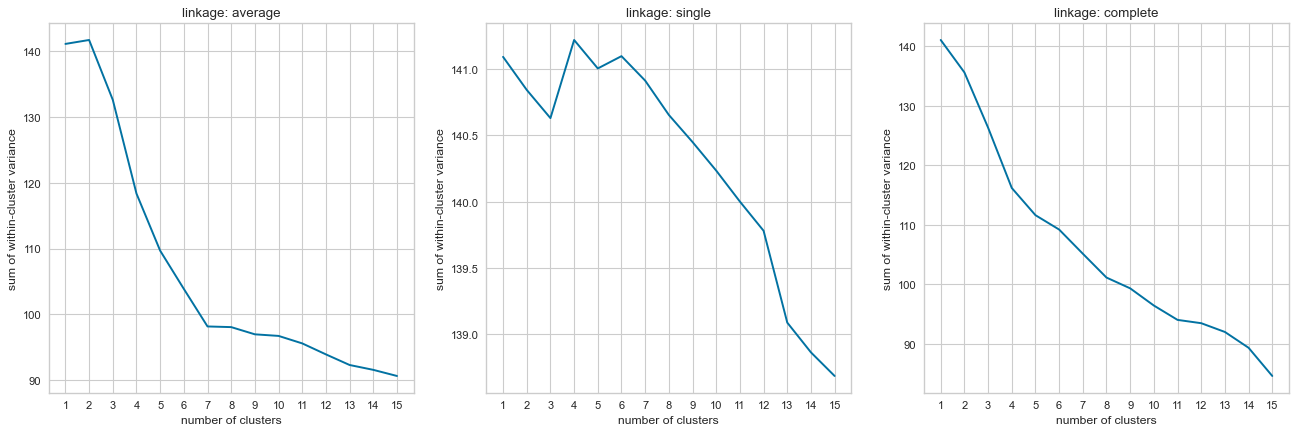

In [40]:
# plot elbow plot for linkage='average'
plt.figure(figsize=(20, 6), dpi=80)
plt.subplot(1,3,1)
plt.plot(range(1,16), cluster_variance_average[:15])
plt.xlabel('number of clusters')
plt.ylabel('sum of within-cluster variance')
plt.title('linkage: average')
plt.xticks(range(1,16))
# plot elbow plot for linkage='single'
plt.subplot(1,3,2)
plt.plot(range(1,16), cluster_variance_single[:15])
plt.xlabel('number of clusters')
plt.ylabel('sum of within-cluster variance')
plt.title('linkage: single')
plt.xticks(range(1,16))
# plot elbow plot for linkage='complete'
plt.subplot(1,3,3)
plt.plot(range(1,16), cluster_variance_complete[:15])
plt.xlabel('number of clusters')
plt.ylabel('sum of within-cluster variance')
plt.title('linkage: complete')
plt.xticks(range(1,16))


In [41]:
clustering_ave = AgglomerativeClustering(n_clusters=7,  metric='precomputed', linkage='average', compute_distances=True).fit(distance_gower)
labels = clustering_ave.labels_

In [44]:
# train a random forest model with cluster labels as target variable and compute the accuracy of the prediction
rf = RandomForestClassifier()
rf.fit(data_prep, labels)
predict = rf.predict(data_prep)
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
accuracy = accuracy_score(labels, predict)
print("Accuracy:", accuracy)

Accuracy: 1.0


In [45]:
importances = rf.feature_importances_

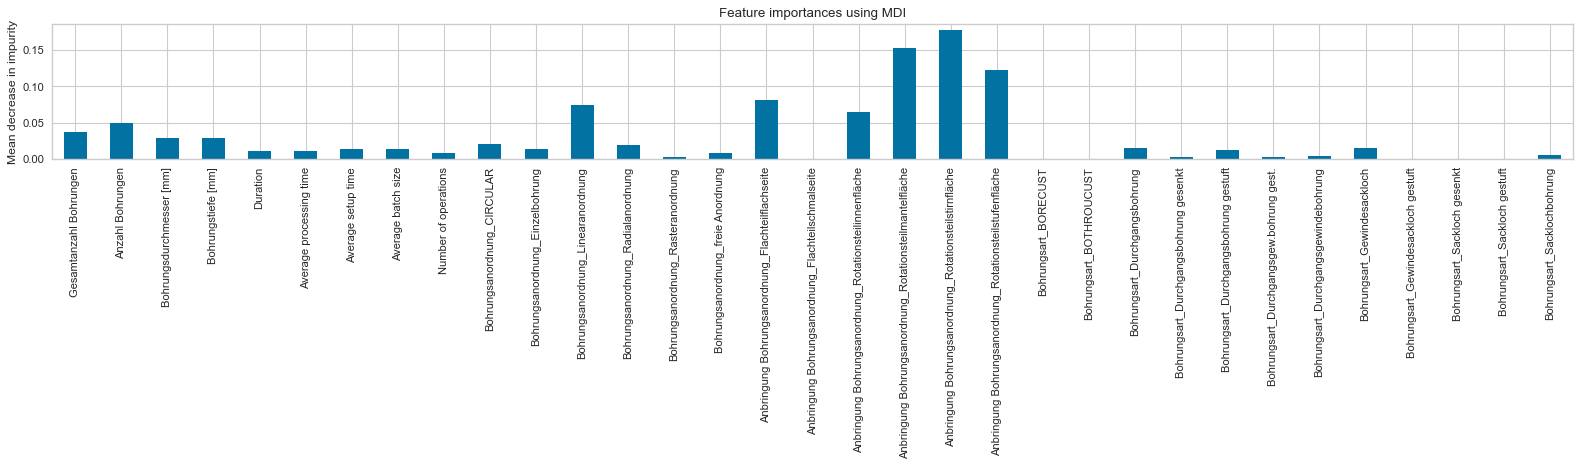

In [47]:
# plot the importances of the features
importances = rf.feature_importances_
forest_importances = pd.Series(importances, index=data_prep.columns)
# set figure size
fig, ax = plt.subplots(figsize=(20, 6), dpi=80)
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [48]:
# add the cluster labels to the dataframe
data2 = data.copy()
data2['cluster'] = labels
data2

,Gesamtanzahl Bohrungen,Anzahl Bohrungen,Bohrungsanordnung,Anbringung Bohrungsanordnung,Bohrungsart,Bohrungsdurchmesser [mm],Bohrungstiefe [mm],Duration,Average processing time,Average setup time,Average batch size,Number of operations,cluster
Fauf,,,,,,,,,,,,,
13343620,32.0,1.0,Einzelbohrung,Rotationsteilmantelfläche,Gewindesackloch gestuft,18.6,52.00,92456.0,2820.000000,3840.000000,2.000000,2.0,6
13343464,14.0,12.0,CIRCULAR,Rotationsteilstirnfläche,Durchgangsbohrung,14.0,111.00,0.0,0.000000,0.000000,1.000000,1.0,1
13343536,27.0,16.0,CIRCULAR,Rotationsteilstirnfläche,Durchgangsbohrung,17.0,87.00,697050.0,2820.000000,3840.000000,2.000000,2.0,1
13342090,113.0,2.0,Linearanordnung,Rotationsteilinnenfläche,Durchgangsbohrung,38.0,90.00,1168995.0,4942.000000,5500.000000,1.000000,9.0,2
13342590,24.0,2.0,Linearanordnung,Rotationsteilmantelfläche,Durchgangsbohrung,15.0,4.97,3160673.0,1237.500000,2160.000000,2.000000,8.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13341677,32.0,4.0,Rasteranordnung,Rotationsteilstufenfläche,Durchgangsbohrung,11.0,12.00,6706738.0,6820.000000,2570.000000,10.000000,6.0,0
13337500,1.0,1.0,Einzelbohrung,Flachteilflachseite,Durchgangsbohrung,470.0,5.00,1283470.0,211808.688000,160.000000,339.173333,6.0,5
13339070,64.0,2.0,Linearanordnung,Rotationsteilstufenfläche,Gewindesackloch,21.0,30.00,5279524.0,4060.106667,3073.333333,2.000000,9.0,2


In [50]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    plt.figure(figsize=(10,10))
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('distance')
    dendrogram(linkage_matrix, **kwargs)

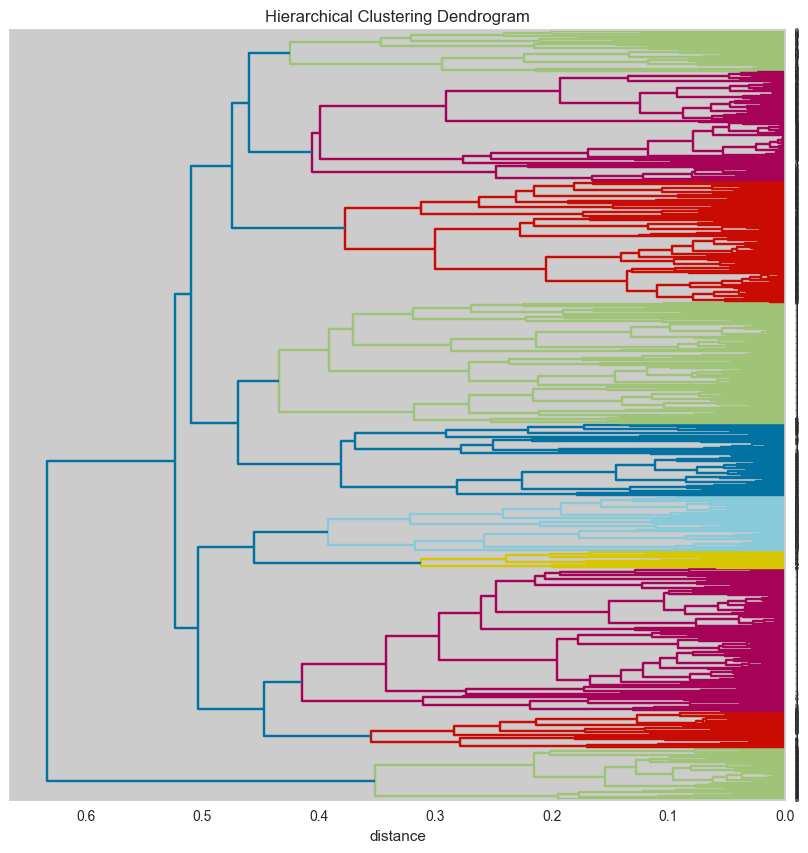

In [51]:
plot_dendrogram(clustering, labels=labels, orientation='left')